# Inversion example of diffusion inversion in 2d

- Importation of the required modules

In [1]:
from pathlib import Path
import copy
import tempfile
from pyrtid import __version__
from pyrtid import InversionExecutor, ForwardModel
from pyrtid.models import ForwardModel
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
from pyrtid.plot import StateVariableSlicePlotter, FieldPlotter
from pyrtid.utils import (
    AdjustableParameter,
    ParameterName,
    Observable,
    TikhonovRegularizator,
    TVRegularizator,
)
from pyrtid.utils.gradient_filtering import GaussianFilter
import numpy as np
from gstools import SRF, Gaussian

In [2]:
print(f"pyrtid version = {__version__}")

pyrtid version = 0.1.0


- Define some configurations for the plots

In [3]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.rcParams.update(new_rc_params)

- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

## Forward problem

- Define a very simple pure diffusion case in 2D.

In [5]:
# We define a function to easily generate a model.
def create_base_model() -> ForwardModel:
    # System parameters
    nx = 21  # number of voxels along the x axis
    ny = 21  # number of voxels along the y axis
    dx = 10.0  # voxel dimension along the x axis
    dy = 10.0  # voxel dimension along the y axis
    nt = 1000  # number of time steps
    dt = 4000.0  # timestep in seconds
    c0 = 0  # general initial cocentration
    D0 = 1e-5  # general initial diffusion coefficient
    w0 = 0.23  # general porosity
    wadv = 0.0  # No avection
    wmin = 0.0  # No mineral dissolution
    return ForwardModel(nx, ny, dx, dy, nt, dt, c0, D0, w0, wadv=wadv, wmin=wmin)

First let's create a model with a "bumped" diffusion coefficient. For this lets create a circular intial distribution for the concenrtation.

In [6]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

    mask = dist_from_center <= radius
    return mask

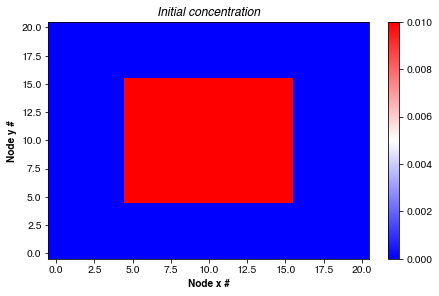

In [7]:
model_reference = create_base_model()
# model_reference.c_init[create_circular_mask(model_reference.nx, model_reference.ny, radius=5)] = 0.01  # [mol/kg]
model_reference.c_init[5:16, 5:16] = 0.01
# Create a Gaussian Covariance Model just for the example
srf = SRF(Gaussian(dim=2, var=1, len_scale=5))
srf(
    (range(model_reference.nx - 1), range(model_reference.ny - 1)),
    mesh_type="structured",
)
# model_reference.diffusion[:, :] = np.abs(srf.structured()) * 1e-3
model_reference.diffusion[:, :] = 1e-3

plotter = FieldPlotter()
plotter.plot_2d_field(
    ax_names=["ax1-1"],
    data={"Initial concentration": model_reference.c_init},
    xlabel="Node x #",
    ylabel="Node y #",
)

Let's imagine that we don't have access to this diffusion coefficient field and that we make some assumptions about the field values. We create a second model.

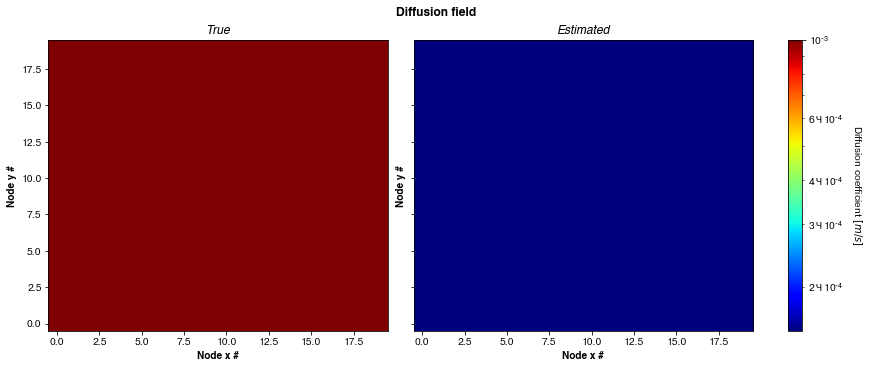

In [8]:
model_estimate = create_base_model()
# Exact diffusion
model_estimate.c_init = model_reference.c_init  # [mol/kg]

model_estimate.D[:, :] = 1.5e-4
# model_estimate.D[7:14, 7:14] = 1.5e-4

plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)
plotter.plot_2d_field(
    ax_names=["ax1-1", "ax1-2"],
    data={"True": model_reference.diffusion, "Estimated": model_estimate.D},
    cbar_title="Diffusion coefficient $[m/s]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet"), "norm": LogNorm()},
    xlabel="Node x #",
    ylabel="Node y #",
)
plotter.subfigs["fig0"].suptitle("Diffusion field", fontweight="bold")

fname = "Diffusion_field_true_vs_estimated"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

We can then run these too models and compare the results

In [9]:
solver_true = ForwardModel(model_reference)
solver_true.solve()

solver_estimate = ForwardModel(model_estimate)
solver_estimate.solve()

We can disply the results in different ways.

Text(0.5, 0.98, 'Tracer concentration')

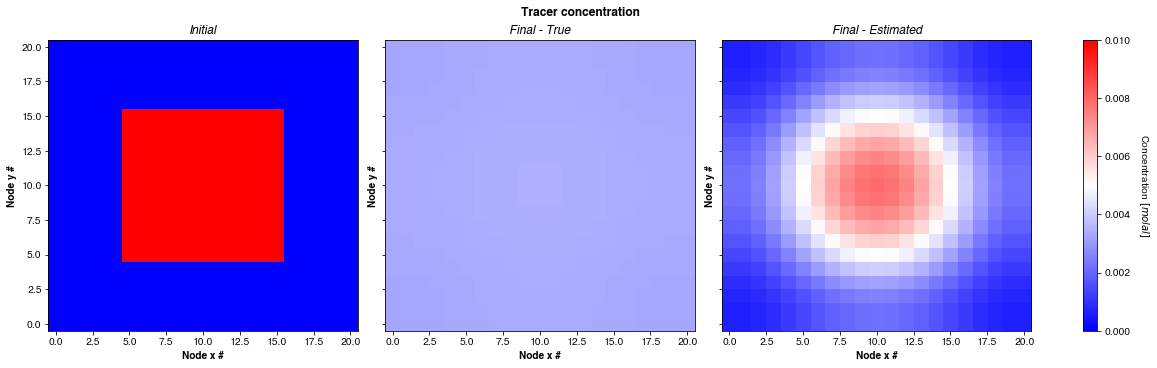

In [10]:
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (16, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)
plotter.plot_2d_field(
    ax_names=["ax1-1", "ax1-2", "ax1-3"],
    data={
        "Initial": model_reference.c_init,
        "Final - True": model_reference.tr_model.conc[:, :, -1],
        "Final - Estimated": model_estimate.tr_model.conc[:, :, -1],
    },
    cbar_title="Concentration $[molal]$",
    xlabel="Node x #",
    ylabel="Node y #",
)
plotter.subfigs["fig0"].suptitle("Tracer concentration", fontweight="bold")

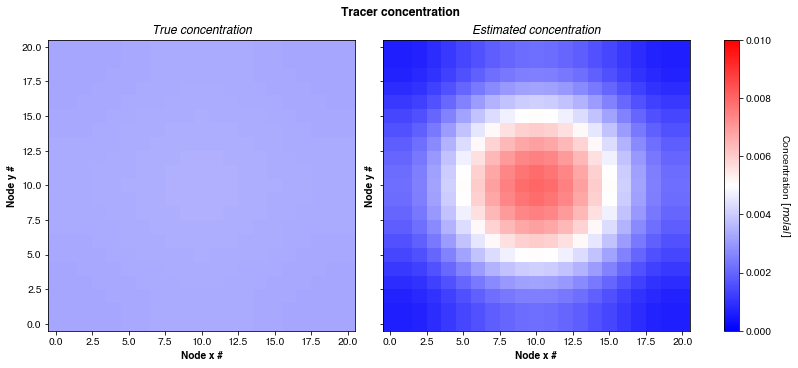

In [11]:
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (11, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)
nb_frames = 40
plotter.plot_2d_animated_field(
    ax_names=["ax1-1", "ax1-2"],
    data={
        "True concentration": model_reference.tr_model.conc,
        "Estimated concentration": model_estimate.tr_model.conc,
    },
    cbar_title="Concentration $[molal]$",
    xlabel="Node x #",
    ylabel="Node y #",
    nb_frames=nb_frames,
)
plotter.subfigs["fig0"].suptitle("Tracer concentration", fontweight="bold")

plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname = fig_save_path.joinpath("conc_2d_animation.html")
writer = HTMLWriter(fps=5)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname, writer=writer)
# plotter.animation.save(fname_gif, writer='pillow', fps=5)

# Display the animation
HTML(fname.read_text())

Let's now consider that we have some observation wells. We can plot what the observation well would sample in both cases and see the difference. Let's place three wells at positions `65m`, `105m` and `155m` (at the center of the nodes).

In [12]:
# locations in the grid
obs_grid_locations = [(7, 7), (7, 13), (13, 7), (13, 13)]
# locations in the plots
obs_plot_locations = [(1, 2), (1, 1), (2, 1), (2, 2)]

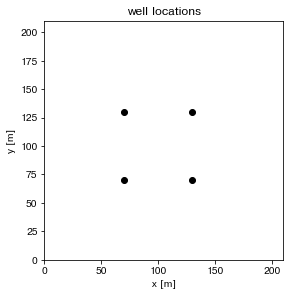

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
# TODO: create a specific plotter for that (support 1 & 2D)
for i, j in obs_grid_locations:
    plt.plot(i * model_reference.dx, j * model_reference.dy, "ko")
plt.xlim(0, model_reference.nx * model_reference.dx)
plt.ylim(0, model_reference.ny * model_reference.dy)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("well locations")
ax.set_aspect("equal", adjustable="box")
fname = "well_locations"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [14]:
target_noise_absolute = 5e-8  # This is an absolute value


def make_noisy(x: np.ndarray) -> np.ndarray:
    """Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return x + np.random.normal(mean_noise, np.sqrt(target_noise_absolute), x.shape)

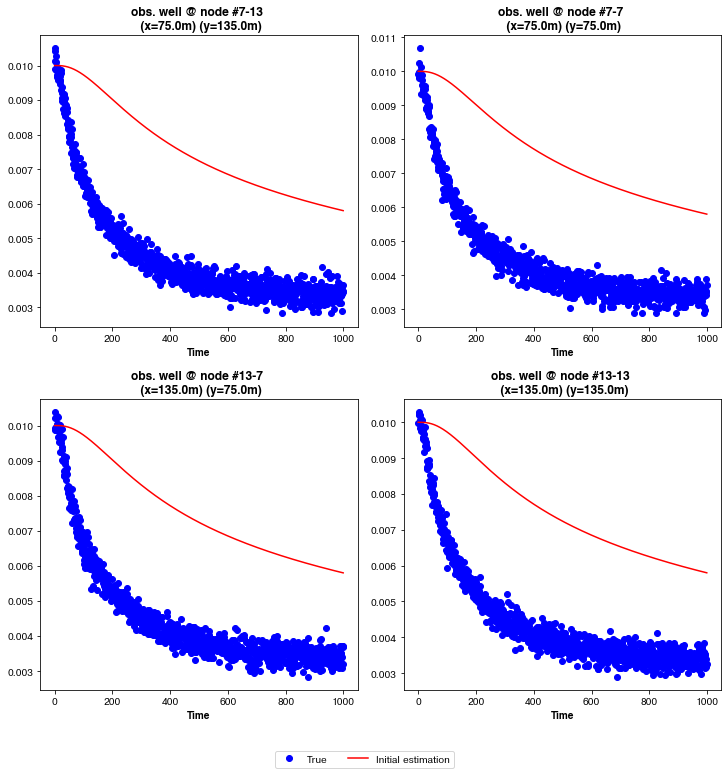

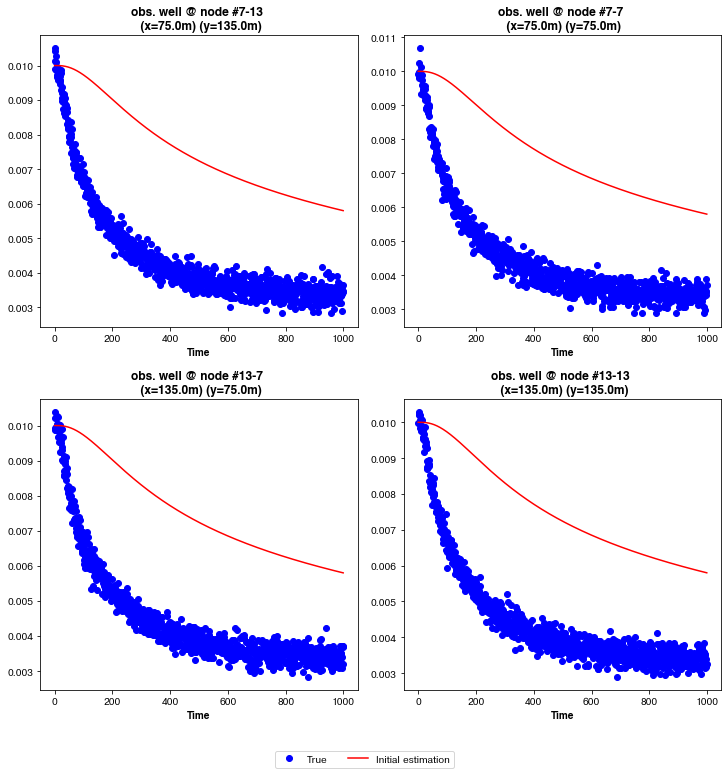

In [15]:
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 10)},
    subfigs_params={
        "nrows": max([elt[0] for elt in obs_plot_locations]),
        "ncols": max([elt[1] for elt in obs_plot_locations]),
    },
)

# Static plot
for (ix, jx), (row_id, col_id) in zip(obs_grid_locations, obs_plot_locations):
    x = (ix + 0.5) * model_reference.dx
    y = (jx + 0.5) * model_reference.dy
    obs_well_name = f"obs. well @ node #{ix}-{jx} \n (x={x}m) (y={y}m)"

    plotter.plot_1d_field(
        ax_name=f"ax{row_id}-{col_id}",
        title=obs_well_name,
        data={
            "True": {
                "data": make_noisy(model_reference.tr_model.conc[ix, jx, :]),
                "kwargs": {"marker": "o", "linestyle": "none", "c": "b"},
            },
            "Initial estimation": {
                "data": model_estimate.tr_model.conc[ix, jx, :],
                "kwargs": {"c": "r"},
            },
        },
        xlabel="Time",
    )
plotter.add_fig_legend(ncol=2)
plotter.fig

## Inversion

### Gradient verification with finite difference

Inversion with three wells. Let's first check if the gradient with ths adjoint state method is correct.

In [16]:
# Create an executor
executor = InversionExecutor(copy.copy(model_estimate))

param = AdjustableParameter(
    name=ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform(),
)

observables = {}
for ix, jx in obs_grid_locations:
    x = (ix + 0.5) * model_reference.dx
    y = (jx + 0.5) * model_reference.dy

    vals = model_reference.tr_model.conc[ix, jx, :]
    timesteps = np.arange(vals.shape[0])

    observables[(ix, jx)] = Observable(
        state_variable="tracer",
        location=(slice(ix, ix + 1, 1), slice(jx, jx + 1, 1)),
        timesteps=timesteps,
        values=vals,
        uncertainties=target_noise_absolute,
    )

is_grad_ok = executor.is_gradient_correct(
    param,
    list(observables.values()),
)
print("Is the gradient correct: ", is_grad_ok)

Is the gradient correct:  True


The gradient seems correct, let's plot it !

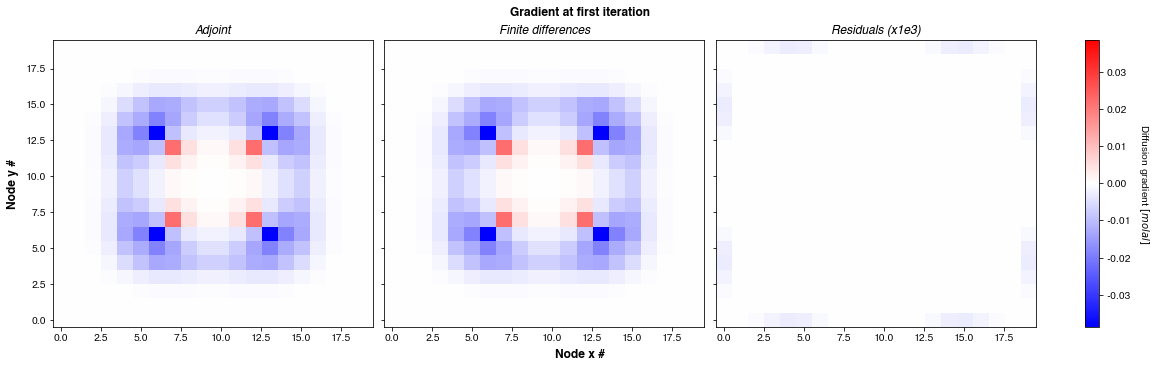

In [20]:
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (16, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

adjoint_grad = executor.rt_solver.get_gridded_gradients(
    ParameterName.DIFFUSION, is_adjoint=True
)[:, :, 0]
fd_grad = executor.rt_solver.get_gridded_gradients(
    ParameterName.DIFFUSION, is_adjoint=False
)[:, :, 0]

plotter.plot_2d_field(
    ax_names=["ax1-1", "ax1-2", "ax1-3"],
    data={
        "Adjoint": adjoint_grad,
        "Finite differences": fd_grad,
        "Residuals (x1e3)": (adjoint_grad - fd_grad) * 1000,
    },
    cbar_title="Diffusion gradient $[molal]$",
    is_symmetric_cbar=True,
)
plotter.subfigs["fig0"].suptitle("Gradient at first iteration", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("Node x #", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Node y #", fontweight="bold")
plotter.savefig("gradient.pdf")

Plot of the adjoint variables

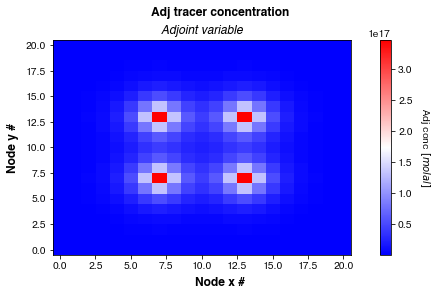

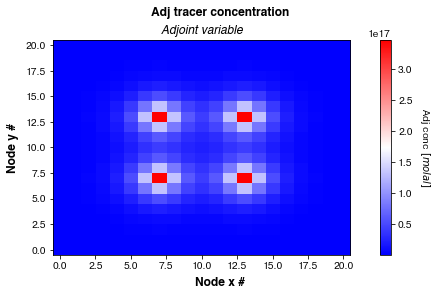

In [18]:
plotter = FieldPlotter()
plotter.plot_2d_field(
    ax_names=["ax1-1"],
    data={
        "Adjoint variable": executor.rt_solver.inverse_model.adj_conc[
            :, :, -500
        ],  # adjoint variables are reversed in time
        # "Adjoint variable": np.flip(executor.rt_solver.inverse_model.adj_conc, axis=2), # adjoint variables are reversed in time
        # "Adjoint variable": executor.rt_solver.inverse_model.adj_conc[0, :, :], # adjoint variables are reversed in time
    },
    cbar_title="Adj conc $[molal]$",
    # Plot with a log scale
    # imshow_kwargs={"norm": LogNorm(vmin=executor.rt_solver.inverse_model.adj_conc.min(), vmax=executor.rt_solver.inverse_model.adj_conc.max())}
)
plotter.subfigs["fig1-1"].suptitle("Adj tracer concentration", fontweight="bold")
plotter.subfigs["fig1-1"].supxlabel("Node x #", fontweight="bold")
plotter.subfigs["fig1-1"].supylabel("Node y #", fontweight="bold")
plotter.fig

KeyboardInterrupt: 

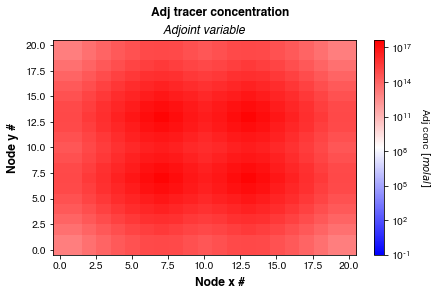

In [19]:
plotter = FieldPlotter()
nb_frames = 30
import matplotlib as mpl

# Set bad (see https://stackoverflow.com/questions/9455044/problems-with-zeros-in-matplotlib-colors-lognorm)
# my_cmap = copy.copy(mpl.cm.get_cmap("bwr")) # copy the default cmap
# my_cmap.set_bad((0, 0, 0))

data = (
    executor.rt_solver.inverse_model.adj_conc[:, :, ::-1] + 1e-1
)  # to avoid zeros with a logscale
plotter.plot_2d_animated_field(
    ax_names=["ax1-1"],
    data={
        "Adjoint variable": data,  # adjoint variables are reversed in time
        # "Adjoint variable": np.flip(executor.rt_solver.inverse_model.adj_conc, axis=2), # adjoint variables are reversed in time
        # "Adjoint variable": executor.rt_solver.inverse_model.adj_conc[0, :, :], # adjoint variables are reversed in time
    },
    cbar_title="Adj conc $[molal]$",
    nb_frames=nb_frames,
    # Plot with a log scale
    imshow_kwargs={"norm": LogNorm(vmax=np.max(data))},
)
plotter.subfigs["fig1-1"].suptitle("Adj tracer concentration", fontweight="bold")
plotter.subfigs["fig1-1"].supxlabel("Node x #", fontweight="bold")
plotter.subfigs["fig1-1"].supylabel("Node y #", fontweight="bold")

plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname = fig_save_path.joinpath("adj_conc_2d_animation.html")
writer = HTMLWriter(fps=2)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname, writer=writer)
# plotter.animation.save(fname_gif, writer='pillow', fps=5)

# Display the animation
HTML(fname.read_text())

At the observatinon well, we can see that the sign of the adjoint variable globally depends on the sign of the residuals.

In [ ]:
plotter = StateVariableSlicePlotter(nb_obs_loc=4, nb_obs_type=2)

for i, (coords, obs) in enumerate(observables.items()):
    ix = coords[0]
    jx = coords[1]
    x = (ix + 0.5) * model_reference.dx
    y = (jx + 0.5) * model_reference.dy
    obs_well_name = f"obs. well @ node (x={x}m) (y={y}m)"

    plotter.plot_state(
        row_id=i,
        obs_well_name=obs_well_name,
        data={
            "Tracer": {
                "True obs.": (
                    executor.rt_solver.inverse_model.observables[i].values,
                    {"c": "b"},
                ),
                "Initial estimation": (
                    executor.rt_solver.model.fwd_conc[ix, jx, :],
                    {"c": "r"},
                ),
            },
            "Tracer adjoint variable": {
                "Adjoint var.": (
                    executor.rt_solver.inverse_model.adj_conc[ix, jx, :],
                    {"c": "g"},
                ),
            },
        },
    )
plotter.add_fig_legend(ncol=2)

plotter.fig

### First inversion run

In [ ]:
# Create an executor
executor = InversionExecutor(copy.copy(model_estimate))

param = AdjustableParameter(
    name=ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform(),
)

observables = {}
for i, coords in enumerate(obs_grid_locations):
    ix = coords[0]
    jx = coords[1]
    x = (ix + 0.5) * model_reference.dx
    y = (jx + 0.5) * model_reference.dy
    obs_well_name = f"obs. well @ node (x={x}m) (y={y}m)"

    vals = model_reference.tr_model.conc[ix, jx, :]
    timesteps = np.arange(vals.shape[0])

    observables[coords] = Observable(
        state_variable="tracer",
        location=(slice(ix, ix + 1, 1), slice(jx, jx + 1, 1)),
        timesteps=timesteps,
        values=model_reference.tr_model.conc[ix, jx, :],
    )

executor.run_inversion(
    param,
    list(observables.values()),
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 30, "maxiter": 30, "ftol": 1e-6, "gtol": 1e-6},
    is_check_gradient=False,
)

Let's plot the results: evolution of the parameter, the gradient, the objective function.

In [ ]:
# Here comes the python code
nx = executor.rt_solver.model.nx - 1  # Finite difference = -1 cell for paraeters
ny = executor.rt_solver.model.ny - 1

adjoint_gradients = executor.rt_solver.get_gridded_gradients(
    ParameterName.DIFFUSION, is_adjoint=True
)

anim_res_plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (13, 8)},
    subfigs_params={"nrows": 2, "ncols": 1},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharex=True, sharey=True),
        "fig1": dict(mosaic=[["ax2-1", "ax2-2"]]),
    },
)

# 1 frame per solver iteration
nb_frames: int = len(executor.rt_solver.inverse_model.loss_scaled_history)

# 1) Gradient evolution
anim_res_plotter.plot_2d_animated_field(
    ax_names=["ax1-1"],
    data={
        "Gradient": adjoint_gradients,
    },
    is_add_grid=True,
    # title="Gradient",
    xlabel="Node x#",
    ylabel="Node y#",
    nb_frames=nb_frames,
    is_symmetric_cbar=True,
)

# 2) Parameter evolution
anim_res_plotter.plot_2d_animated_field(
    ax_names=["ax1-2", "ax1-3"],
    data={
        "True": np.repeat(
            model_reference.diffusion.reshape(nx, ny, -1), nb_frames, axis=2
        ),
        "inverted": np.transpose(np.array(param.archived_values), axes=[1, 2, 0]),
    },
    is_add_grid=True,
    # title="Gradient",
    xlabel="Node x#",
    ylabel="Node y#",
    nb_frames=nb_frames,
    cbar_title="Diffusion coefficient $[m/s]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet"), "norm": LogNorm()},
)

# 3) Objective function
vals = executor.rt_solver.inverse_model.loss_scaled_history
obj_fun_vals = np.full((nb_frames, len(vals)), fill_value=np.nan)
for i in range(len(vals)):
    obj_fun_vals[i, : i + 1] = vals[: i + 1]

anim_res_plotter.plot_1d_animated_field(
    ax_name="ax2-1",
    nb_frames=nb_frames,
    data={
        "Obj fun": {"data": obj_fun_vals.T, "kwargs": {"c": "r", "linestyle": "--"}},
    },
    title="Objective function",
    xlabel="Iteration #",
)
anim_res_plotter.ax_dict["ax2-1"].set_yscale("log")
# grad_plotter.add_fig_legend(ncol=2)
# grad_plotter.fig

# 4) Observation vs predicted values
anim_res_plotter.plot_observed_vs_simulated(
    ax_name="ax2-2",
    obs_vector=executor.rt_solver.inverse_model.get_obs_values_as_1d_vector() * 1000,
    pred_vector=executor.rt_solver.get_results_matching_obs_vector() * 1000,
    # pred_vector_initial=model_estimate.get_results_matching_obs_vector() * 1000,
    unit="$mmol.l^{-1}$",
)

anim_res_plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname = fig_save_path.joinpath("m_j_g_animation..html")
writer = HTMLWriter(fps=2)
writer.frame_format = "svg"  # Ensure svg format
anim_res_plotter.animation.save(fname, writer=writer)
# plotter.animation.save(fname_gif, writer='pillow', fps=5)

# Display the animation
HTML(fname.read_text())

In [ ]:
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 10)},
    subfigs_params={
        "nrows": max([elt[0] for elt in obs_plot_locations]),
        "ncols": max([elt[1] for elt in obs_plot_locations]),
    },
)

# Static plot
for (ix, jx), (row_id, col_id) in zip(obs_grid_locations, obs_plot_locations):
    x = (ix + 0.5) * model_reference.dx
    y = (jx + 0.5) * model_reference.dy
    obs_well_name = f"obs. well @ node #{ix}-{jx} \n (x={x}m) (y={y}m)"

    plotter.plot_1d_field(
        ax_name=f"ax{row_id}-{col_id}",
        title=obs_well_name,
        data={
            "True": {
                "data": model_reference.tr_model.conc[ix, jx, :],
                "kwargs": {"c": "g"},
            },
            "Initial estimation": {
                "data": model_estimate.tr_model.conc[ix, jx, :],
                "kwargs": {"c": "r"},
            },
            "Inverted": {
                "data": executor.rt_solver.model.fwd_conc[ix, jx, :],
                "kwargs": {"c": "b"},
            },
        },
        xlabel="Time",
    )
plotter.add_fig_legend(ncol=2)
plotter.fig

# Impact of the regularization

We create three different models:
- The first without regularization
- The second with a tickonov regularization
- The third with a TV regularization

In [ ]:
param_no_reg = AdjustableParameter(
    name=ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform()
)

param_reg_tikhonov = AdjustableParameter(
    name=ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform()
    regularizators=[
        TikhonovRegularizator(
            model_reference.dx, model_reference.dy, axis=0, is_preconditioned=True
        ),
        TikhonovRegularizator(
            model_reference.dx, model_reference.dy, axis=1, is_preconditioned=True
        ),
    ],
)

param_reg_tv = AdjustableParameter(
    name=ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform()
    regularizators=[
        TVRegularizator(
            model_reference.dx, model_reference.dy, axis=0, is_preconditioned=True
        ),
        TVRegularizator(
            model_reference.dx, model_reference.dy, axis=1, is_preconditioned=True
        ),
    ],
)

In [ ]:
# Common arguments for solvers
common_kwargs = dict(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 30, "maxiter": 30, "ftol": 1e-6, "gtol": 1e-6},
    max_optimization_round_nb=3,
    is_check_gradient=False,
)

# Running the inversion without regularization
executor_no_reg = InversionExecutor(model_estimate)
executor_no_reg.run_inversion(param_no_reg, list(observables.values()), **common_kwargs)

# Running the inversion with tikhonov regularization
executor_tikhonov = InversionExecutor(model_estimate)
executor_tikhonov.run_inversion(
    param_reg_tikhonov, list(observables.values()), **common_kwargs
)

# Running the inversion with total variation regularization
executor_tv = InversionExecutor(model_estimate)
executor_tv.run_inversion(param_reg_tv, list(observables.values()), **common_kwargs)

Let's see the results in term of inverted parameter.

In [ ]:
# Here comes the python code
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (13, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2"], ["ax2-1", "ax2-2"]], sharex=True, sharey=True
        ),
    },
)

# Get the parameter to plot
plotter.plot_2d_field(
    ax_names=["ax1-1", "ax1-2", "ax2-1", "ax2-2"],
    data={
        "True": model_reference.diffusion,
        "No regularization": param_no_reg.archived_values[-1],
        "Thickonov": param_reg_tikhonov.archived_values[-1],
        "Total variation": param_reg_tv.archived_values[-1],
    },
    cbar_title="Diffusion coefficient $[m/s]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet"), "norm": LogNorm()},
    # title="No regularization",
    # ylabel="Diffusivity (m/s)",
    # xlabel="Nodes #"
)

plotter.fig.suptitle("Impact of the regularization on the final inverted parameter")
plotter.fig